<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 4.7MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=e79c45f154b4d2c4ccec895388723e7dc855309699ad5c94aa2ddcb4c975d2fc
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pathlib
import re
from urllib.parse import urljoin

In [3]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [4]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [5]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [6]:
import pandas as pd

In [7]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [8]:
df_kanja.shape

(1591, 10)

In [9]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      1589 non-null   Int64 
 1   発表日     1589 non-null   object
 2   年代      1589 non-null   object
 3   性別      1589 non-null   object
 4   管轄      1589 non-null   object
 5   居住地     1589 non-null   object
 6   職業      1588 non-null   object
 7   発症日     1589 non-null   object
 8   渡航歴     1589 non-null   object
 9   備考欄     1588 non-null   object
dtypes: Int64(1), object(9)
memory usage: 126.0+ KB


In [10]:
df_kanja.count()

番号     1589
発表日    1589
年代     1589
性別     1589
管轄     1589
居住地    1589
職業     1588
発症日    1589
渡航歴    1589
備考欄    1588
dtype: int64

# 前処理

In [11]:
import datetime

import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates
import numpy as np

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [12]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [13]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [14]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [15]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja.drop(738, inplace=True)

In [16]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [17]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [18]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

In [19]:
df_kanja.to_csv("kanja.tsv", sep="\t")

# 経過日数確認

## 経過日数グラフ

Text(0.98, 0.85, 'median: 6.0')

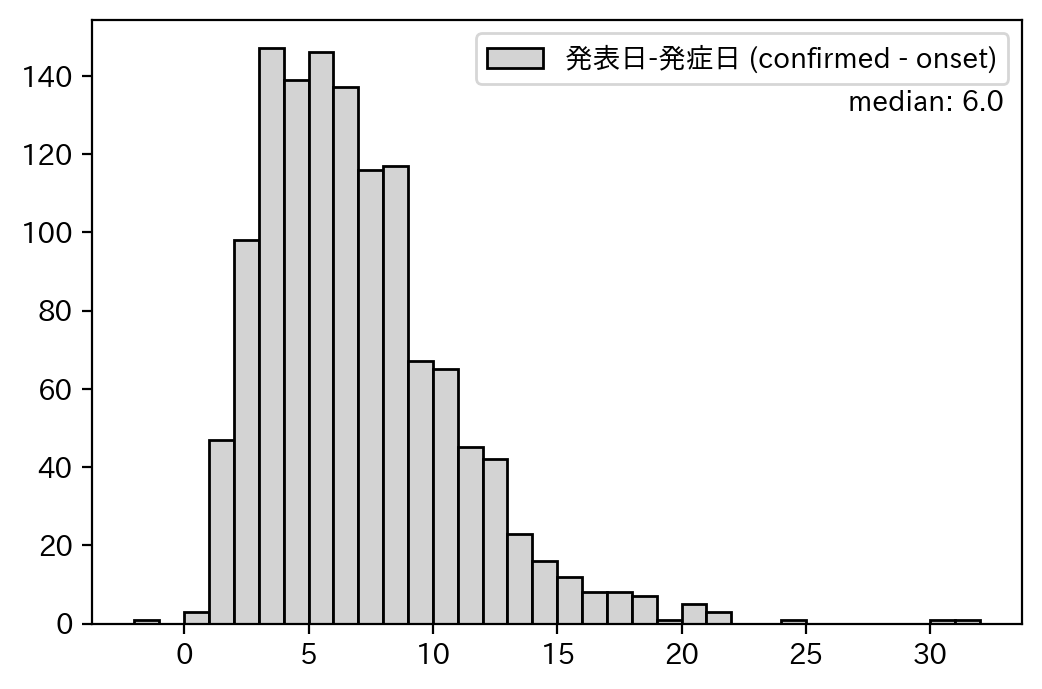

In [20]:
df_kanja["経過日数"] = (df_kanja["発表日"] - df_kanja["発症日"]).dt.days

df_kanja["経過日数"].dropna(inplace=True)

fig, ax = plt.subplots()
ax.hist(df_kanja["経過日数"], bins=np.arange(min(df_kanja["経過日数"]), max(df_kanja["経過日数"])+2), color="lightgray", edgecolor="black")
ax.legend(['発表日-発症日 (confirmed - onset)'])
ax.text(0.98, 0.85, 'median: ' + str(np.median(df_kanja["経過日数"])), horizontalalignment='right', transform=ax.transAxes)

## 経過日数一覧

In [21]:
df_kanja["経過日数"].value_counts().sort_index()

-2.0       1
 0.0       3
 1.0      47
 2.0      98
 3.0     147
 4.0     139
 5.0     146
 6.0     137
 7.0     116
 8.0     117
 9.0      67
 10.0     65
 11.0     45
 12.0     42
 13.0     23
 14.0     16
 15.0     12
 16.0      8
 17.0      8
 18.0      7
 19.0      1
 20.0      5
 21.0      3
 24.0      1
 30.0      1
 31.0      1
Name: 経過日数, dtype: int64

# 発症日グラフ

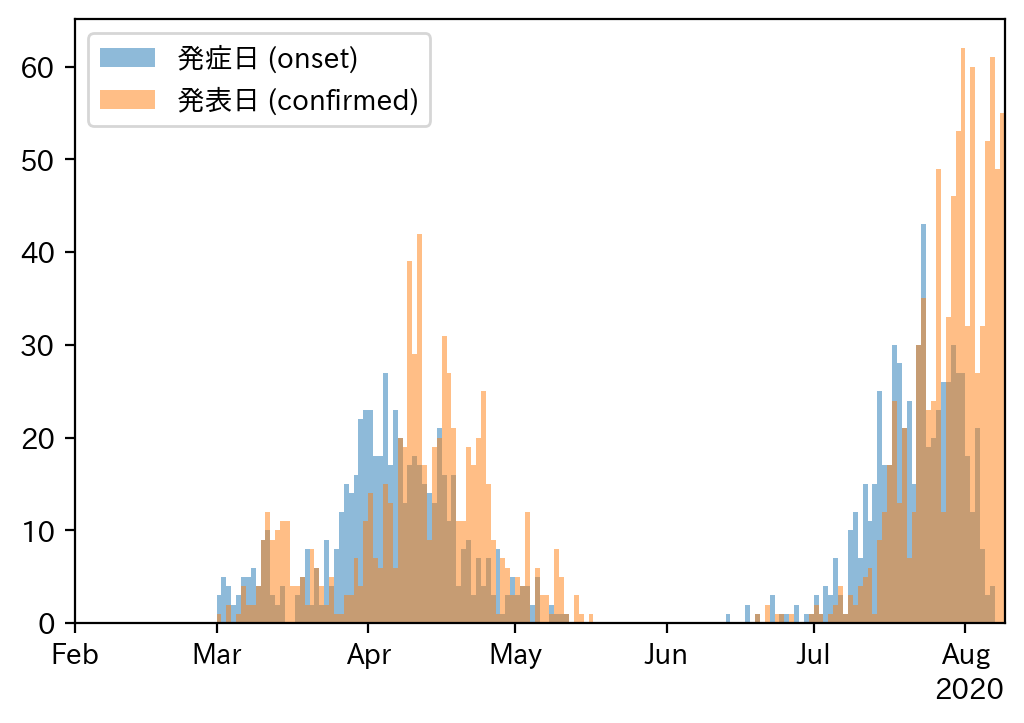

In [22]:
b = np.arange(min(min(df_kanja['発表日']), min(df_kanja['発症日'])),
              max(max(df_kanja['発表日']), max(df_kanja['発症日'])) + datetime.timedelta(days=2),
              datetime.timedelta(days=1))

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.hist(df_kanja['発症日'].values, bins=b, alpha=0.5) # edgecolor="black"
ax.hist(df_kanja['発表日'].values, bins=b, alpha=0.5)
ax.legend(['発症日 (onset)', '発表日 (confirmed)'])
ax.set_xlim(datetime.datetime(2020,2,1), b[-1])
fig.savefig('200312a.svg', bbox_inches="tight")

# 年代確認

## 年代別グラフ

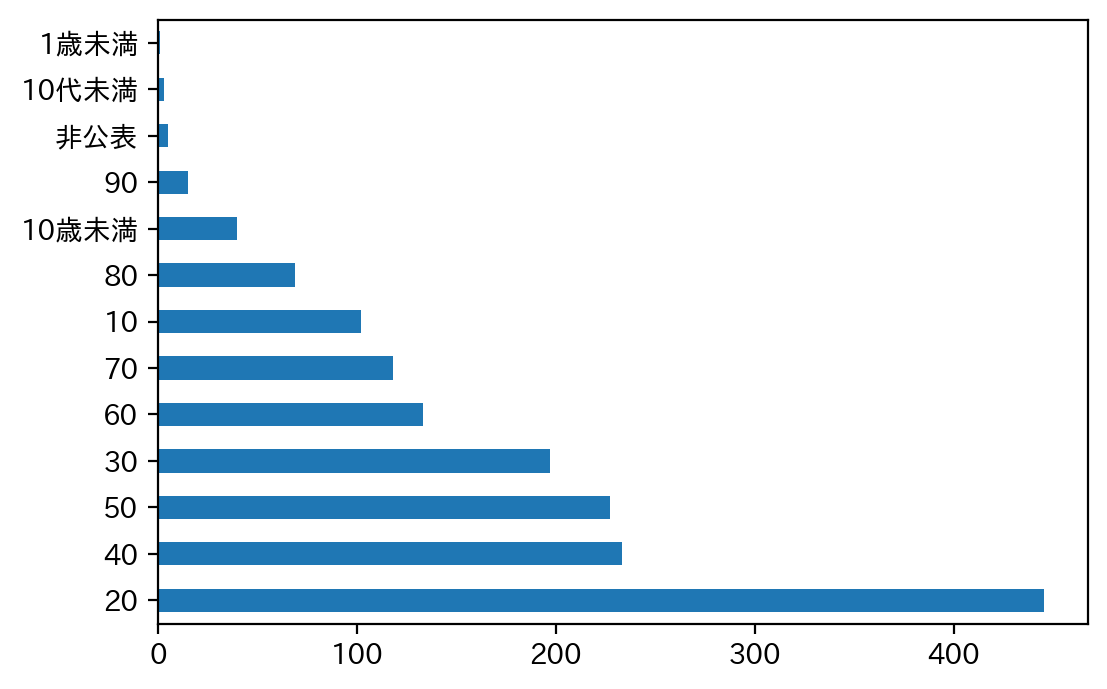

In [23]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [24]:
df_kanja["年代"].value_counts()

20       445
40       233
50       227
30       197
60       133
70       118
10       102
80        69
10歳未満     40
90        15
非公表        5
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

In [25]:
df_kanja[df_kanja["年代"] == "10代未満"]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし,NaN
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0


# 性別確認

## 性別別グラフ

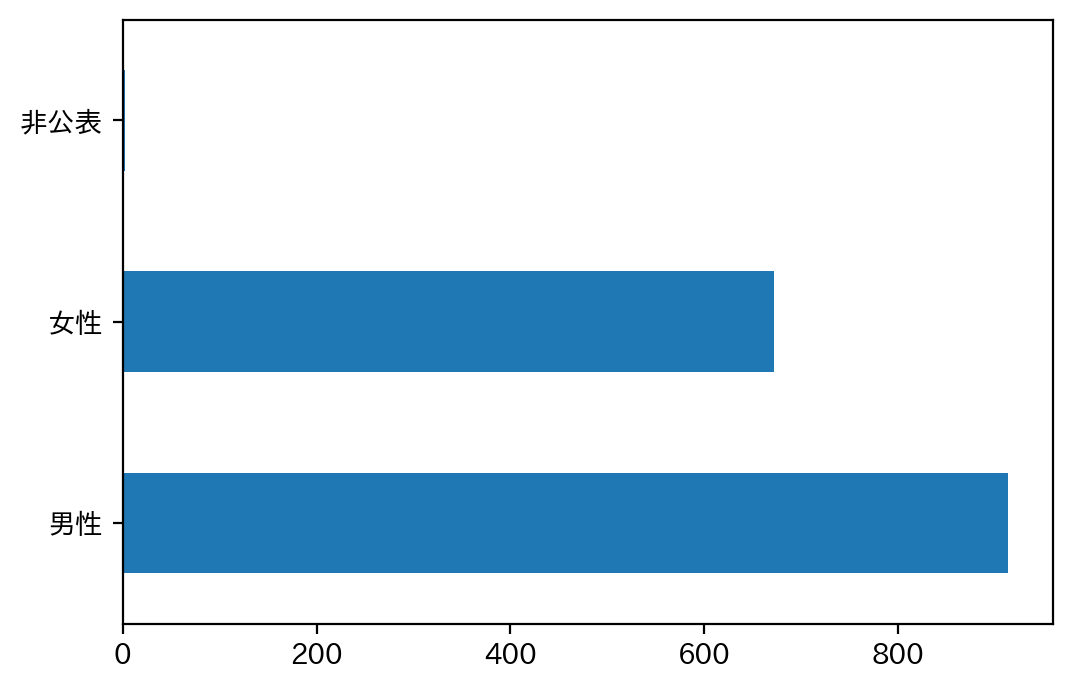

In [26]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [27]:
df_kanja["性別"].value_counts()

男性     914
女性     672
非公表      2
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

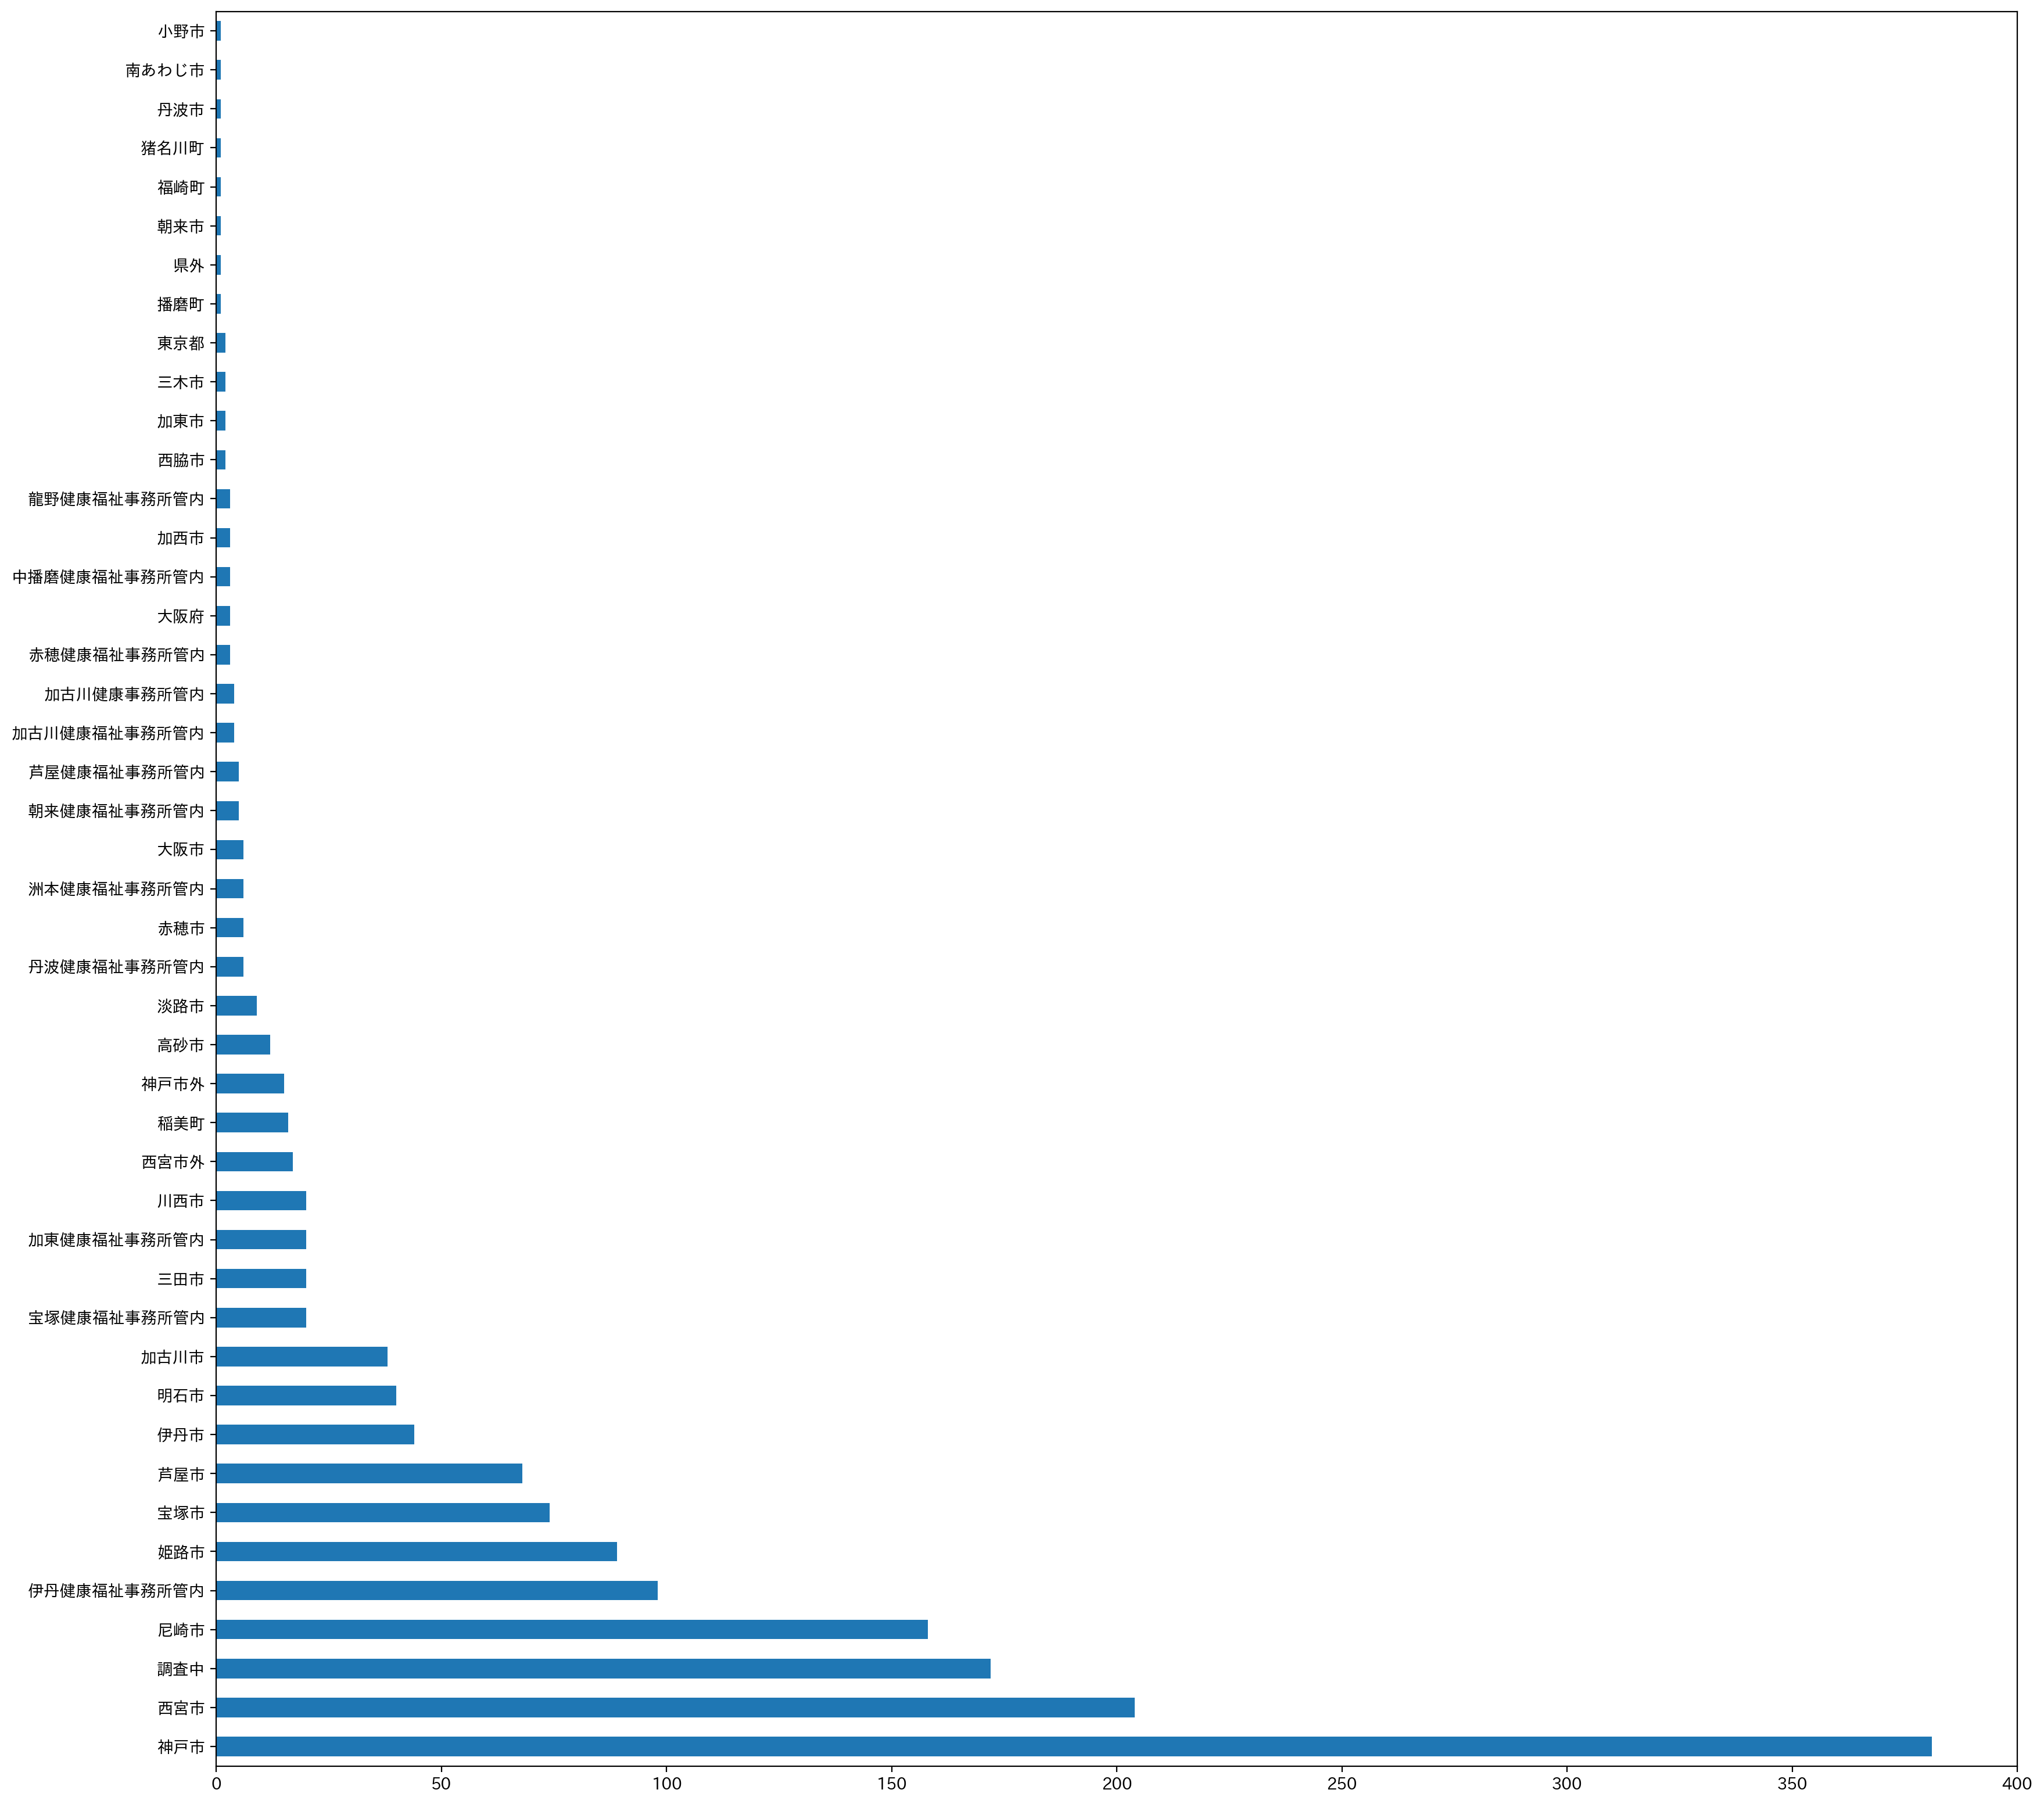

In [28]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [29]:
df_kanja["居住地"].value_counts()

神戸市             381
西宮市             204
調査中             172
尼崎市             158
伊丹健康福祉事務所管内      98
姫路市              89
宝塚市              74
芦屋市              68
伊丹市              44
明石市              40
加古川市             38
宝塚健康福祉事務所管内      20
三田市              20
加東健康福祉事務所管内      20
川西市              20
西宮市外             17
稲美町              16
神戸市外             15
高砂市              12
淡路市               9
丹波健康福祉事務所管内       6
赤穂市               6
洲本健康福祉事務所管内       6
大阪市               6
朝来健康福祉事務所管内       5
芦屋健康福祉事務所管内       5
加古川健康福祉事務所管内      4
加古川健康事務所管内        4
赤穂健康福祉事務所管内       3
大阪府               3
中播磨健康福祉事務所管内      3
加西市               3
龍野健康福祉事務所管内       3
西脇市               2
加東市               2
三木市               2
東京都               2
播磨町               1
県外                1
朝来市               1
福崎町               1
猪名川町              1
丹波市               1
南あわじ市             1
小野市               1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

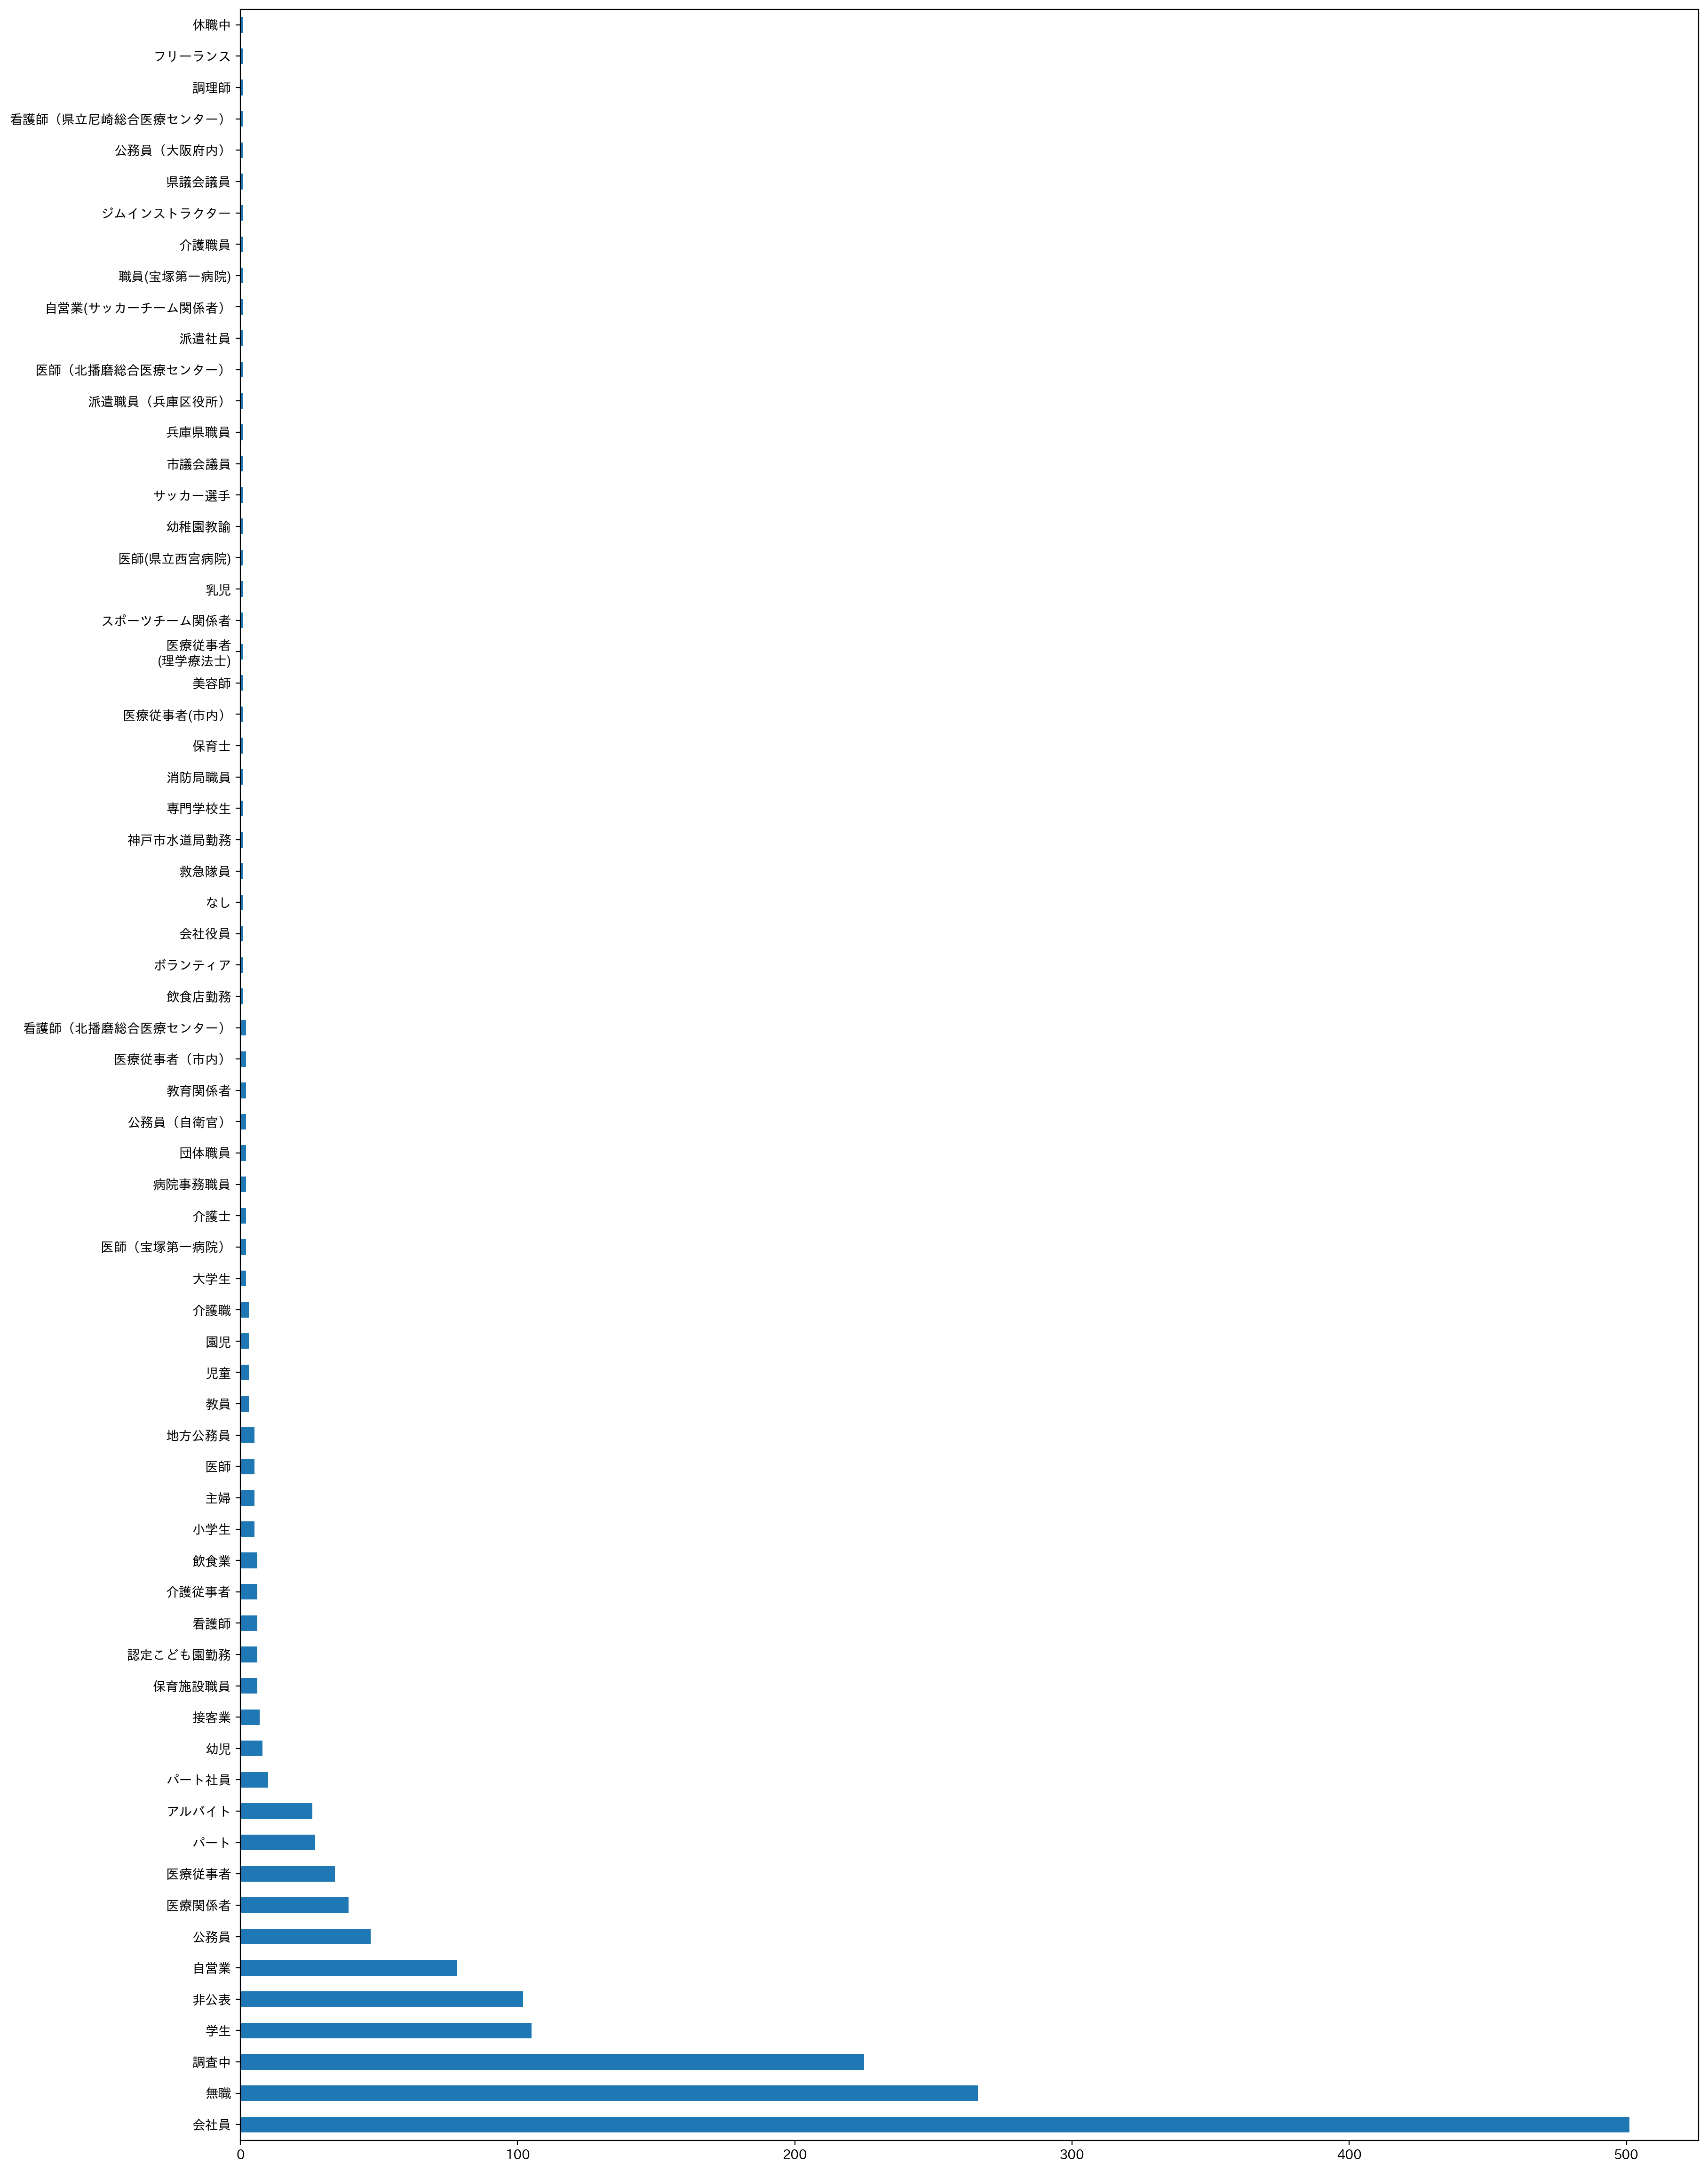

In [30]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [31]:
df_kanja["職業"].value_counts()

会社員                  501
無職                   266
調査中                  225
学生                   105
非公表                  102
                    ... 
公務員（大阪府内）              1
看護師（県立尼崎総合医療センター）      1
調理師                    1
フリーランス                 1
休職中                    1
Name: 職業, Length: 68, dtype: int64

# 管轄確認

## 管轄別グラフ

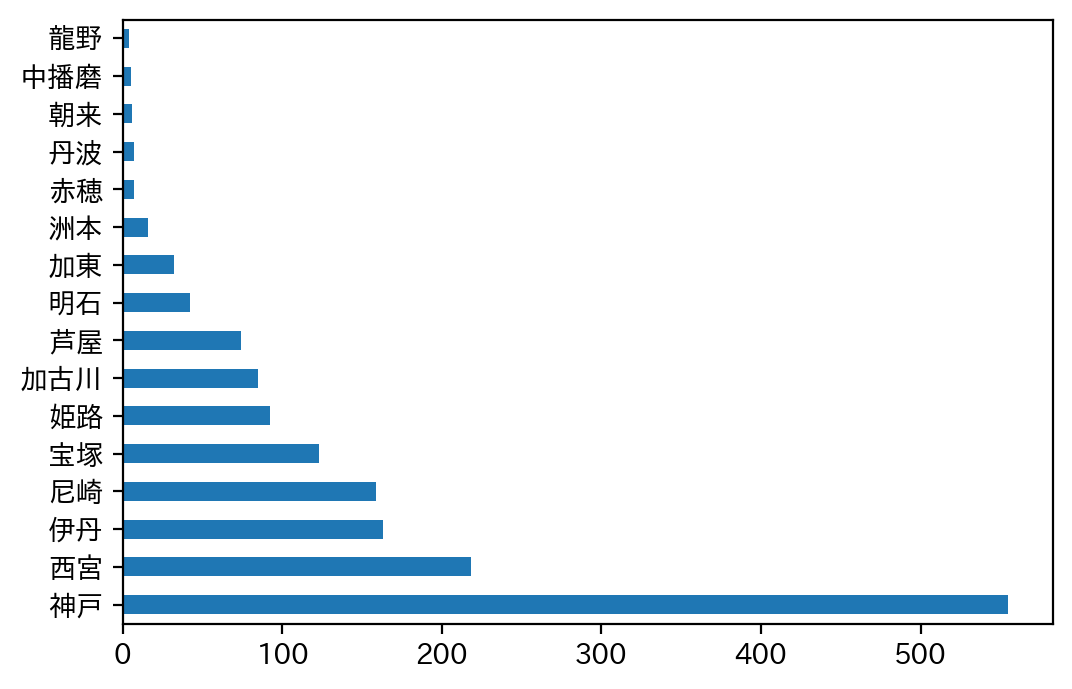

In [32]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [33]:
df_kanja["管轄"].value_counts()

神戸     555
西宮     218
伊丹     163
尼崎     159
宝塚     123
姫路      92
加古川     85
芦屋      74
明石      42
加東      32
洲本      16
赤穂       7
丹波       7
朝来       6
中播磨      5
龍野       4
Name: 管轄, dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

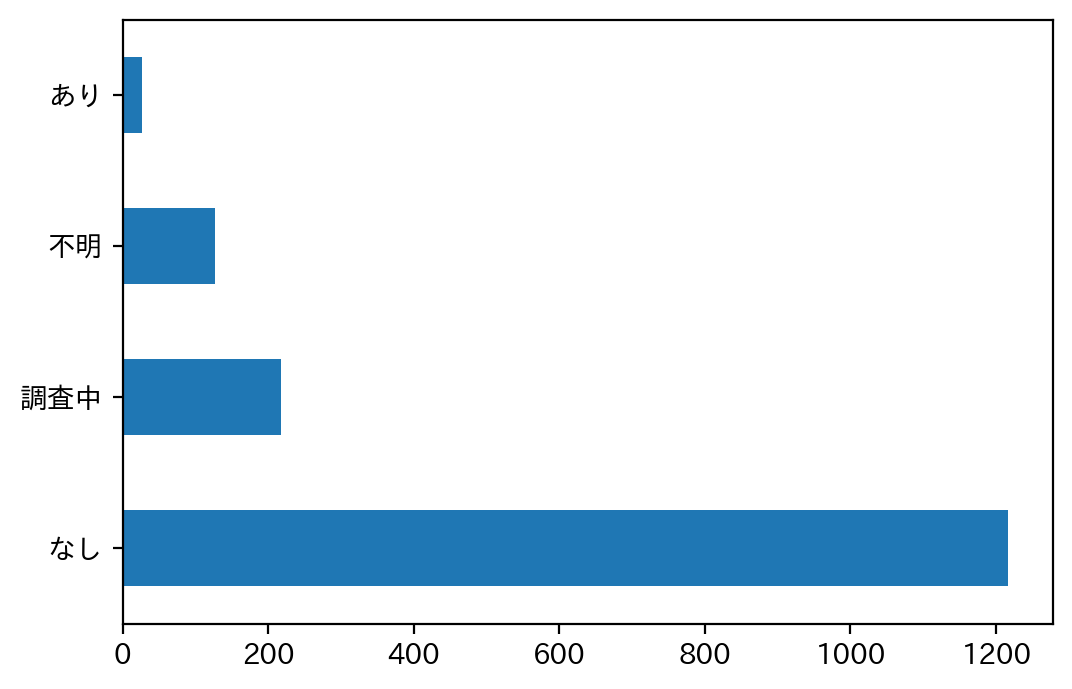

In [34]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [35]:
df_kanja["渡航歴"].value_counts()

なし     1217
調査中     218
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

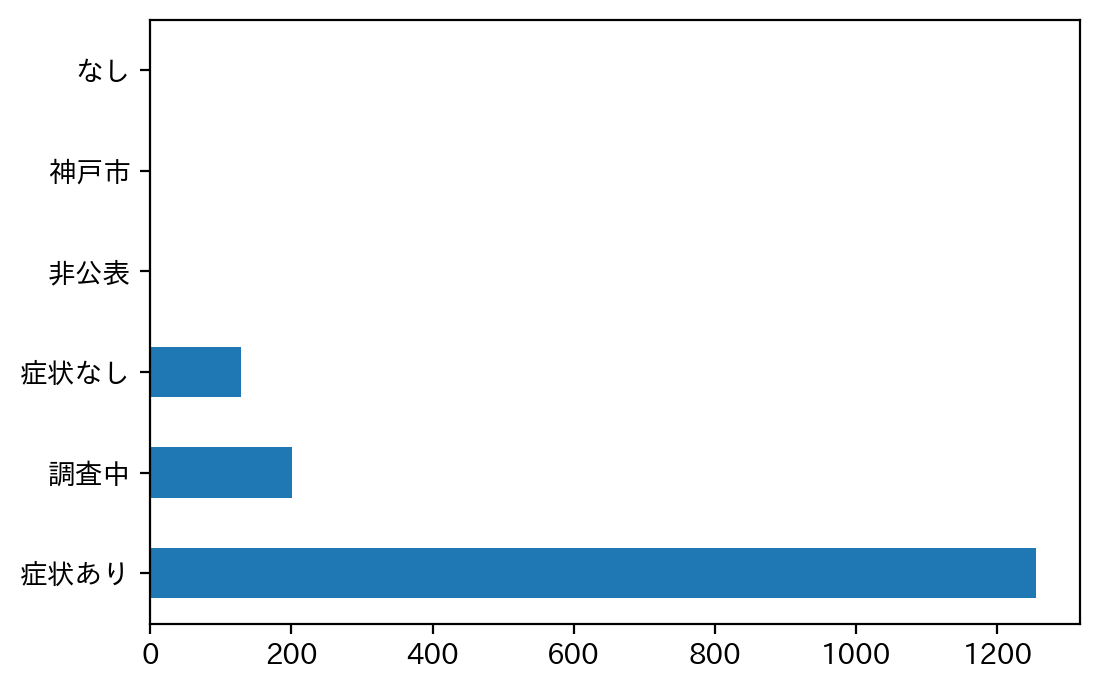

In [36]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [37]:
df_kanja["ステータス"].value_counts()

症状あり    1256
調査中      201
症状なし     128
非公表        1
神戸市        1
なし         1
Name: ステータス, dtype: int64

# 全体確認

In [38]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1589,2020-08-08,70,男性,朝来,朝来健康福祉事務所管内,非公表,NaT,なし,陽性患者の濃厚接触者,症状なし,NaN
1588,2020-08-08,60,男性,朝来,朝来健康福祉事務所管内,非公表,2020-07-29,なし,陽性患者の濃厚接触者,症状あり,10.0
1587,2020-08-08,60,女性,朝来,朝来健康福祉事務所管内,非公表,2020-07-18,なし,陽性患者の濃厚接触者,症状あり,21.0
1586,2020-08-08,40,女性,加東,加東健康福祉事務所管内,非公表,2020-08-03,なし,行動歴調査中,症状あり,5.0
1585,2020-08-08,40,女性,加古川,加古川市,非公表,2020-07-31,なし,陽性患者の濃厚接触者,症状あり,8.0
...,...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり,12.0
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,12.0
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,11.0


# ファイル保存

In [39]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [40]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [41]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# ダウンロード

In [42]:
from google.colab import files

In [43]:
files.download(f"陽性者一覧（年齢別）_{dt_now}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PCR

In [44]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [45]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [46]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-08-04,607,360,224,23,32
2020-08-05,775,347,392,36,52
2020-08-06,653,288,320,45,61


In [47]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [48]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [49]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [50]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [51]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [52]:
df_yousei = df_yousei.fillna(0).astype(int)

In [53]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [54]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [55]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [56]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 年代

In [57]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, 90, "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
637,2020-04-28,1歳未満,男性,伊丹,川西市,乳児,2020-04-15,なし,No.635の子,症状あり,13.0
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし,NaN
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0


### 居住地

In [58]:
nlist = df_kanja.loc[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "事務所管内")) & ~(df_kanja["居住地"] == "調査中"), "居住地"].unique()
df_kanja[df_kanja["居住地"].isin(nlist)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [59]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし,NaN
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市,NaN


### 渡航歴

In [60]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [61]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [62]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [63]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 累計前日差チェック

In [64]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [65]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [66]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [67]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [68]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
